In [3]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import ttest_ind

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [4]:
"""

Define some functions to plot with.

"""


def pairwise_ttest(df, group_column, value,
                   combinations=[],
                   correction=True):

    # get combos
    if len(combinations) == 0:
        order = sorted(set(df[group_column]))
        combinations = itertools.combinations(order, 2)
        combinations = list(combinations)
    pairwisedf = []
    max_order = {}
    for c1, c2 in combinations:
        # t-test
        t1 = df[df[group_column].isin([c1])][value].values
        t2 = df[df[group_column].isin([c2])][value].values
        t_res = ttest_ind(t1, t2)   
        # tdf
        t_res = pd.DataFrame(t_res,
                             ['test-stat','P'],
                             [c1 + ' vs. ' + c2])
        pairwisedf.append(t_res)
        max_= max(max(t1),max(t2))
        max_order[c1 + ' vs. ' + c2] = max_
    # merge
    pairwisedf = pd.concat(pairwisedf, axis=1).T
    # bonfer correct
    if correction:
        pairwisedf['P'] = pairwisedf['P'] * len(combinations)
    else:
        pairwisedf['P'] = pairwisedf['P'] * len(combinations)
    return pairwisedf, max_order


def swarmbox_plot(df, ax, y, x, order, palette='Set1'):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  data=df,
                  palette=palette,
                  order=order,
                  ax=ax, s=10)
    sns.boxplot(y=y, x=x,
                data=df,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('%s ($\\mu$M)' % y.capitalize(),
                  fontsize=26, color='black')
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax

def swarmbox_plot_hue(df, ax, y, x, hue, order,
                      hue_order, palette='Set1'):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  hue = hue,
                  dodge=True,
                  data=df,
                  hue_order=hue_order,
                  palette=palette,
                  order=order,
                  ax=ax, s=10)
    sns.boxplot(y=y, x=x,
                hue=hue,
                data=df,
                hue_order=hue_order,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('%s ($\\mu$M)' % y.capitalize(),
                  fontsize=26, color='black')
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax


## First experiment

In [8]:
# import data
measures = pd.read_csv('data/metagenomics/physiological-measures/sfca-acetate.csv')
measures.index = 'sample-' + measures.index.astype(str)
measures.rename({'Unnamed: 0':'treatment'},
                axis=1, inplace=True)
measures.head(3)


,treatment,Acetate,Propionate,Butyrate,Isovalerate,Valerate
sample-0,Control,364.326725,14.334223,11.246810,2.474567,4.436745
sample-1,Control,204.961466,12.483968,9.471586,2.457321,3.719765
sample-2,Control,243.478081,13.451759,11.679507,2.117088,3.203936


In [9]:
# prepare to plot
acetatedf = measures[['Acetate','treatment']]

# prepare to plot
sfcadf = measures[['Propionate','Butyrate',
                   'Isovalerate','Valerate',
                   'treatment']]
sfcadf = pd.melt(sfcadf, id_vars=['treatment']) 


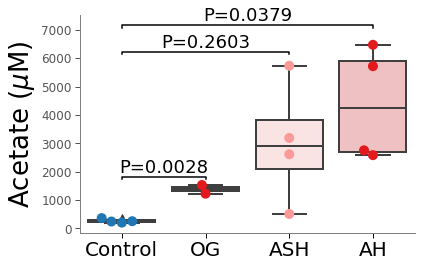

In [10]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1, figsize=(6,4))

# plot
order = ['Control','OG','ASH','AH']
pallette = {'Control':'#1f78b4',
            'OG':'#e31a1c',
            'ASH':'#fb9a99',
            'AH':'#e31a1c'}

ax = swarmbox_plot(acetatedf, ax,
                   'Acetate',
                   'treatment',
                   order,
                   palette=pallette)
# get stats
statdf, max_order = pairwise_ttest(acetatedf,
                                   'treatment',
                                   'Acetate')

# annotate by order
i1 = 0 
c1 = order[0]
for i2, c2 in enumerate(order[1:]):
    # annot x-axis
    x1, x2 = i1, (i2 + 1)
    # get label
    label_ = c1 + ' vs. ' + c2
    if label_ not in statdf.index:
        label_ = c2 + ' vs. ' + c1
    # get stat
    p_ = statdf.loc[label_, 'P']
    p_ = 'P=%.4f' % (p_)
    # heights
    y, h, col = max_order[label_] + 200 * (i2+1), 100, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=18)  

# save the figure to file
plt.savefig('results/plots/acetate.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()

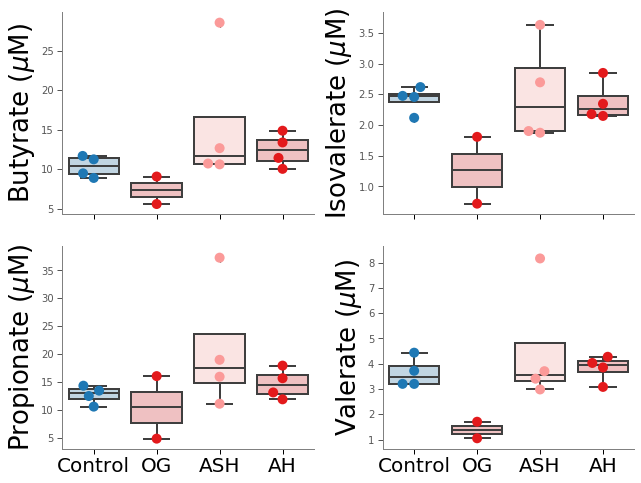

In [11]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 10

n_comapre = len(set(sfcadf.variable))

fig, axn = plt.subplots(2, 2,
                       figsize=(9, 7),
                       sharex=True)

order = ['Control','OG','ASH','AH']
treatment_col = 'treatment'
pallette = {'Control':'#1f78b4',
            'OG':'#e31a1c',
            'ASH':'#fb9a99',
            'AH':'#e31a1c'}


for ax, (variable_col, dfplot) in zip(axn.flatten(), sfcadf.groupby('variable')):
    
    # fix
    dfplot = dfplot.drop('variable', axis=1)
    dfplot = dfplot.rename({'value': variable_col}, axis=1)

    # plot
    ax = swarmbox_plot(dfplot, ax,
                       variable_col,
                       treatment_col,
                       order,
                       palette=pallette)
    # get stats
    statdf, max_order = pairwise_ttest(dfplot,
                                       treatment_col,
                                       variable_col)

plt.tight_layout()

# save the figure to file
plt.savefig('results/plots/scfas.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

## Second Experiment

In [17]:
# dose
dosedf = pd.read_csv('data/metagenomics/physiological-measures/gta-dose-time.csv')
dosedf.index = 'sample-' + dosedf.index.astype(str)
# mouse measures
phenodf = pd.read_csv('data/metagenomics/physiological-measures/gta-treatment-phenotype-measurements.csv')
phenodf.index = 'sample-' + phenodf.index.astype(str)
#SCFA
scfadf = pd.read_csv('data/metagenomics/physiological-measures/gta-scfa.csv')
scfadf.index = 'sample-' + scfadf.index.astype(str)


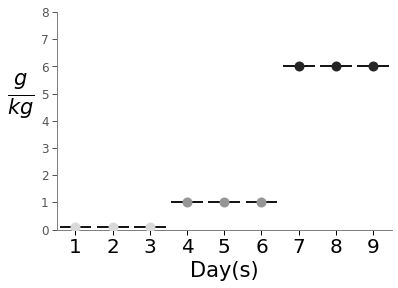

In [18]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1, figsize=(6,4))

# plot
order = [int(v) for v in sorted(dosedf.Days)]
pallette = {1:'#d9d9d9', 2:'#d9d9d9', 3:'#d9d9d9',
             4:'#969696', 5:'#969696', 6:'#969696',
             7:'#252525', 8:'#252525', 9:'#252525'}

ax = swarmbox_plot(dosedf, ax,
                   'g/kg',
                   'Days',
                   order,
                   palette=pallette)
ax.set_xlabel('Day(s)',
              fontsize=21,
              color='black')
ax.set_ylabel('$\\frac{g}{kg}$',
              fontsize=30,
              labelpad=20,
              rotation=0,
              color='black')
ax.set_ylim(0,8)

# save the figure to file
plt.savefig('results/plots/doses.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()



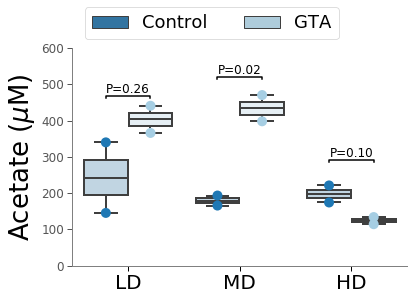

In [19]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12

fig, ax = plt.subplots(1,1, figsize=(6,4))

# plot
scfadf['treatment-dose'] = scfadf['treatment'] \
                            + '-' + scfadf['done']
hueorder = ['Control','GTA']
order = ['LD','MD','HD']
pallette = {'Control':'#1f78b4',
            'GTA':'#a6cee3'}

ax = swarmbox_plot_hue(scfadf, ax,
                       'Acetate',
                       'done',
                       'treatment',
                       order,
                       hueorder,
                       palette=pallette)

# get stats
combo = [('Control-LD','GTA-LD'),
         ('Control-MD','GTA-MD'),
         ('Control-HD','GTA-HD')]
statdf, max_order = pairwise_ttest(scfadf,
                                   'treatment-dose',
                                   'Acetate',
                                   combinations=combo,
                                   correction=False)
 
# annotate by order
for i1, c1 in enumerate(order):
    # annot x-axis
    x1, x2 = (i1 -.2), (i1 + .2)
    # get label
    label_ = 'Control-'+c1 + ' vs. GTA-' + c1
    if label_ not in statdf.index:
        label_ = 'Control-'+c1 + ' vs. GTA-' + c1
    # get stat
    p_ = statdf.loc[label_, 'P'] / 3
    p_ = 'P=%.2f' % (p_)
    # heights
    y, h, col = max_order[label_] + 22 * (i1+1), 5, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=12)  


# add a legend
ax.set_ylim(0,600)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.01, 1.23),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# save the figure to file
plt.savefig('results/plots/GTA-dose-acetate.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()

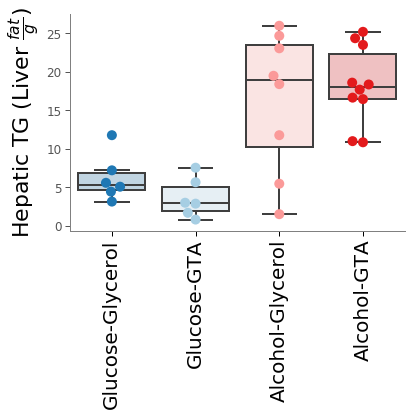

In [20]:

plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1, figsize=(6,4))

# plot
x_axis = 'HEPATIC TG (mg fat/g liver)'
phenodf['treatment'] = phenodf['Tx1'] + '-' + phenodf['Tx2'] 
order = ['Glucose-Glycerol', 'Glucose-GTA',
         'Alcohol-Glycerol', 'Alcohol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
         'Glucose-GTA':'#a6cee3',
         'Alcohol-Glycerol':'#fb9a99',
         'Alcohol-GTA':'#e31a1c'}


ax = swarmbox_plot(phenodf, ax,
                    x_axis,
                   'treatment',
                   order,
                   palette=pallette)

# relabel
ax.set_ylabel('Hepatic TG (Liver $\\frac{fat}{g}$)',
              fontsize=22,
              color='black')
ax.tick_params(axis='x', rotation=90)


# save the figure to file
plt.savefig('results/plots/HEPATIC-GTA.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()



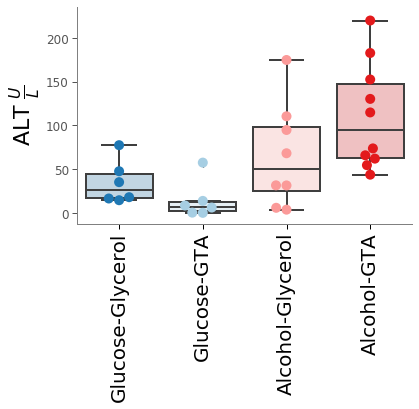

In [21]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots(1,1, figsize=(6,4))

# plot
x_axis = 'ALT (u/l)'
phenodf['treatment'] = phenodf['Tx1'] + '-' + phenodf['Tx2'] 
order = ['Glucose-Glycerol', 'Glucose-GTA',
         'Alcohol-Glycerol', 'Alcohol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
         'Glucose-GTA':'#a6cee3',
         'Alcohol-Glycerol':'#fb9a99',
         'Alcohol-GTA':'#e31a1c'}


ax = swarmbox_plot(phenodf, ax,
                    x_axis,
                   'treatment',
                   order,
                   palette=pallette)
# get stats
statdf, max_order = pairwise_ttest(phenodf,
                                   'treatment',
                                    x_axis)

# relabel
ax.set_ylabel('ALT $\\frac{U}{L}$',
              fontsize=22,
              color='black')
ax.tick_params(axis='x', rotation=90)


# save the figure to file
plt.savefig('results/plots/ALT-GTA.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()
